In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [63]:
import numpy as np

import torch
import random
import math
import json

from tqdm import tqdm_notebook
from boltons.iterutils import pairwise
from scipy.stats import kendalltau
from itertools import permutations

from sent_order.models.kt_regression import SentenceEncoder, Regressor, Corpus
from sent_order.perms import sample_uniform_perms

In [4]:
sent_encoder = torch.load(
    '../../data/models/new/kt-reg/sent_encoder.366.bin',
    map_location={'cuda:0': 'cpu'},
)

In [5]:
regressor = torch.load(
    '../../data/models/new/kt-reg/regressor.366.bin',
    map_location={'cuda:0': 'cpu'},
)

/Users/dclure/Projects/plot-ordering/env/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'sent_order.models.kt_regression.Regressor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
train = Corpus('../../data/dev.json/', 10000)

100%|██████████| 10000/10000 [00:01<00:00, 6913.28it/s]


In [352]:
grafs = [g for g in train.grafs if len(g.sentences) == 5]

In [353]:
len(grafs)

1647

In [367]:
graf = random.choice(grafs)

In [368]:
[' '.join(s.tokens) for s in graf.sentences]

['We present a theoretical study on the behavior under pressure of the two hypothetical C$ _ { 46}$ and Li$_8$C$_{46}$ type - I carbon clathrates in order to bring new informations concerning their synthesis .',
 'Using \\textit{ab initio } calculations , we have explored the energetic and structural properties under pressure of these two carbon based cage - like materials .',
 'These low - density meta - stable phases show large negative pressure transitions compared to diamond which represent a serious obstacle for their synthesis .',
 'However , we evidence that a minimum energy barrier can be reached close to 40 GPa , suggesting that the synthesis of the Li - clathrate under extreme conditions of pressure and temperature may be possible .',
 'Electronic band structure with related density of states behavior under pressure as well as the dependence of the active Raman modes with pressure are also examined .']

In [369]:
sents = sent_encoder(graf.sentence_variables())

In [370]:
sents

Variable containing:
-1.2818e-02  8.3766e-05  1.0842e-02  ...  -6.0201e-04 -3.8426e-04 -2.3172e-01
-4.2273e-05 -1.2040e-04 -1.1228e-03  ...   1.5111e-02  5.0324e-03  4.5415e-08
-2.5915e-03  4.1907e-03 -2.6644e-03  ...   2.1427e-02 -1.2866e-04 -1.1777e-07
-2.4552e-02 -2.8971e-03 -4.0795e-02  ...  -1.0916e-02  1.3985e-04  3.2984e-02
 1.3111e-05 -2.3127e-05 -2.9298e-02  ...  -2.7485e-02 -1.8725e-04 -1.9765e-03
[torch.FloatTensor of size 5x1000]

In [371]:
perms = list(permutations(range(5)))

In [372]:
x = []
kts = []
for perm in tqdm_notebook(perms):
    
    sort = torch.LongTensor(perm)
    x.append(sents[sort])
    
    kt = kendalltau(perm, range(5)).correlation
    kts.append(kt)

HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

In [373]:
x = torch.stack(x)
y = regressor(x)

In [374]:
y = (1-y)*2-1

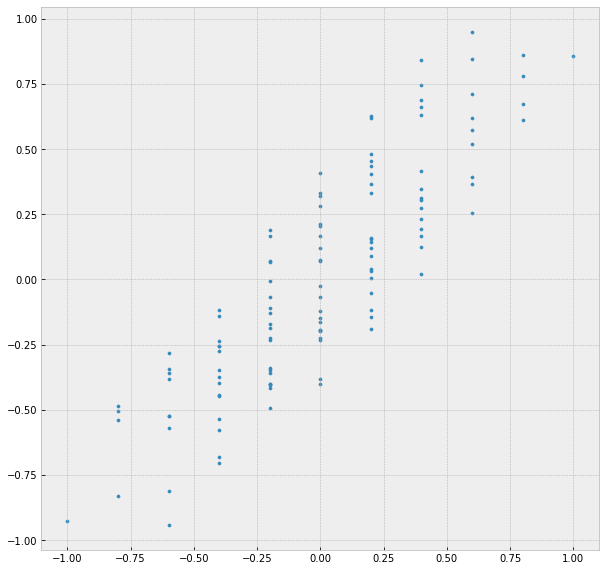

In [375]:
plt.figure(figsize=(10,10))
plt.scatter(kts, y.data.tolist(), s=10)

In [376]:
zeros = []
for perm, kt_true, kt_pred in zip(perms, kts, y.data.tolist()):
    if kt_true == 0:
        zeros.append((perm, kt_true, kt_pred))

In [378]:
sorted(zeros, key=lambda x: x[2])

[((3, 1, 2, 0, 4), 0.0, -0.40004587173461914),
 ((1, 3, 2, 4, 0), 0.0, -0.3819553852081299),
 ((2, 1, 3, 4, 0), 0.0, -0.23398339748382568),
 ((2, 3, 0, 4, 1), 0.0, -0.2243180274963379),
 ((1, 3, 4, 0, 2), 0.0, -0.19834351539611816),
 ((3, 1, 0, 4, 2), 0.0, -0.19468045234680176),
 ((2, 3, 1, 0, 4), 0.0, -0.1937624216079712),
 ((3, 0, 2, 4, 1), 0.0, -0.16538238525390625),
 ((3, 2, 0, 1, 4), 0.0, -0.14733779430389404),
 ((3, 0, 4, 1, 2), 0.0, -0.12115561962127686),
 ((1, 2, 4, 3, 0), 0.0, -0.06863832473754883),
 ((1, 4, 2, 0, 3), 0.0, -0.025311708450317383),
 ((0, 3, 4, 2, 1), 0.0, 0.07233965396881104),
 ((2, 1, 4, 0, 3), 0.0, 0.07602560520172119),
 ((2, 4, 0, 1, 3), 0.0, 0.11895585060119629),
 ((1, 4, 0, 3, 2), 0.0, 0.16687297821044922),
 ((2, 0, 4, 3, 1), 0.0, 0.20374643802642822),
 ((4, 1, 0, 2, 3), 0.0, 0.21372616291046143),
 ((4, 0, 1, 3, 2), 0.0, 0.279726505279541),
 ((0, 4, 3, 1, 2), 0.0, 0.318259596824646),
 ((4, 0, 2, 1, 3), 0.0, 0.3296201229095459),
 ((0, 4, 2, 3, 1), 0.0, 0.409